In [1]:
import os
import pandas
from definitions import ROOT_DIR

mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNAs = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_nsclc_miRNAs.csv'))

print "mirna_tumor_df.shape", mirna_tumor_df.shape
print "mirna_normal_df.shape", mirna_normal_df.shape
print 'validated_miRNAs.shape', validated_miRNAs.shape

X_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
X_normal['pathologic_stage'] = 'normal'
X_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}

X_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

print X_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print X_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882)
mirna_normal_df.shape (46, 1882)
validated_miRNAs.shape (110, 1)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## We now create data matrixes from tumor vs normal samples

In [2]:
from sklearn import preprocessing

X = pandas.concat([X_normal, X_tumor]).dropna(subset=['pathologic_stage'])
Y = X['pathologic_stage']

X_normal_vs_I = X[X['pathologic_stage'].isin(['normal', 'Stage I'])]
X_normal_vs_II = X[X['pathologic_stage'].isin(['normal', 'Stage II'])]
X_normal_vs_III = X[X['pathologic_stage'].isin(['normal', 'Stage III'])]
X_normal_vs_IV = X[X['pathologic_stage'].isin(['normal', 'Stage IV'])]

Y_normal_vs_I = X_normal_vs_I['pathologic_stage']
Y_normal_vs_II = X_normal_vs_II['pathologic_stage']
Y_normal_vs_III = X_normal_vs_III['pathologic_stage']
Y_normal_vs_IV = X_normal_vs_IV['pathologic_stage']

X_normal_vs_I.__delitem__('patient_barcode')
X_normal_vs_I.__delitem__('pathologic_stage')
X_normal_vs_II.__delitem__('patient_barcode')
X_normal_vs_II.__delitem__('pathologic_stage')
X_normal_vs_III.__delitem__('patient_barcode')
X_normal_vs_III.__delitem__('pathologic_stage')
X_normal_vs_IV.__delitem__('patient_barcode')
X_normal_vs_IV.__delitem__('pathologic_stage')

X.__delitem__('patient_barcode')
X.__delitem__('pathologic_stage')

print 'miRNA null values', X.isnull().sum().sum()
print 'Y null values', Y.isnull().sum()

print "X.shape", X.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
validated_miRNAs = set(validated_miRNAs['miRNA'].tolist())

# Scale miRNA expressions to unit variance
X_scaler = preprocessing.StandardScaler(with_mean=False).fit(X)
X_normal_vs_I = X_scaler.transform(X_normal_vs_I)
X_normal_vs_II = X_scaler.transform(X_normal_vs_II)
X_normal_vs_III = X_scaler.transform(X_normal_vs_III)
X_normal_vs_IV = X_scaler.transform(X_normal_vs_IV)

miRNA null values 0
Y null values 0
X.shape (552, 1881)
Y.shape (552,)


In [3]:
print "mirna_list", len(mirna_list)
print 'validated_miRNAs', len(validated_miRNAs)

print "number of validated miRNAs in list of all miRNAs", len(validated_miRNAs & set(mirna_list))

mirna_list 1881
validated_miRNAs 110
number of validated miRNAs in list of all miRNAs 109


## Perform classification

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import numpy as np

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0, 10000))
# print 'X_train', X_train.shape, ', y_train', y_train.shape
# print 'X_test', X_test.shape, ', y_test', y_test.shape

normal_vs_I = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
normal_vs_II = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
normal_vs_III = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
normal_vs_IV = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
print normal_vs_I.fit(X_normal_vs_I, Y_normal_vs_I)
print normal_vs_II.fit(X_normal_vs_II, Y_normal_vs_II)
print normal_vs_III.fit(X_normal_vs_III, Y_normal_vs_III)
print normal_vs_IV.fit(X_normal_vs_IV, Y_normal_vs_IV)

# print "\nClassification_report on training"
# print metrics.classification_report(y_train, model.predict(X_train), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print "classification_report on testing"
# print metrics.classification_report(y_test, model.predict(X_test), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print metrics.confusion_matrix(y_test, model.predict(X_test), 
#                                labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])

LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,

In [41]:
from src.utils.validate_candidate_miRNAs import percent_candidate_in_validated as pciv
results = []

for model, name in zip([normal_vs_I, normal_vs_II, normal_vs_III, normal_vs_IV], ['normal_vs_I', 'normal_vs_II', 'normal_vs_III', 'normal_vs_IV']):
    print '\n', name 
    non_zero_idx = np.nonzero(model.coef_.ravel())[0]
    print "Non-zero coef:", non_zero_idx.size
    df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                           "coefficient": model.coef_.ravel()[non_zero_idx]})
    print df.sort_values(by='coefficient', ascending=False).head(6)
    print df.sort_values(by='coefficient', ascending=True).head(6)
    print "Percentage of known NSCLC miRNAs:", pciv(df['mirna'].tolist(), validated_miRNAs)
    print set(df['mirna'].tolist()) & validated_miRNAs, len(set(df['mirna'].tolist()) & validated_miRNAs)
    results.append(df)


normal_vs_I
Non-zero coef: 184
     coefficient          mirna
179     0.927528   hsa-mir-7108
105     0.749796   hsa-mir-4529
109     0.563179   hsa-mir-4655
130     0.555693  hsa-mir-486-2
27      0.547929    hsa-mir-144
26      0.504786    hsa-mir-143
     coefficient         mirna
167    -1.085341  hsa-mir-6787
7      -0.938149  hsa-mir-106a
178    -0.674254   hsa-mir-7-1
153    -0.668082   hsa-mir-628
47     -0.657947    hsa-mir-21
91     -0.640079  hsa-mir-4443
Percentage of known NSCLC miRNAs: 0.290909090909
set(['hsa-mir-15a', 'hsa-mir-21', 'hsa-mir-218-2', 'hsa-mir-218-1', 'hsa-mir-497', 'hsa-mir-148a', 'hsa-mir-143', 'hsa-mir-200b', 'hsa-mir-378a', 'hsa-mir-182', 'hsa-mir-186', 'hsa-mir-34a', 'hsa-mir-1-1', 'hsa-mir-30a', 'hsa-mir-1-2', 'hsa-mir-29c', 'hsa-mir-708', 'hsa-mir-17', 'hsa-mir-150', 'hsa-mir-199b', 'hsa-mir-155', 'hsa-mir-625', 'hsa-mir-199a-2', 'hsa-mir-7-1', 'hsa-mir-96', 'hsa-mir-106a', 'hsa-mir-135b', 'hsa-mir-133b', 'hsa-mir-199a-1', 'hsa-mir-146a', 'hsa-let

[0.5, 0.5, 0.5, 0.90144927536231889, 0.96086956521739131, 0.9746376811594204, 0.98550724637681164, 0.98985507246376803, 0.98840579710144927]
[0.5, 0.5, 0.5, 0.5, 0.96833333333333327, 0.98666666666666669, 0.9933333333333334, 0.99833333333333329, 0.99666666666666659]
[0.5, 0.5, 0.5, 0.5, 0.94523809523809532, 0.94761904761904769, 0.95714285714285718, 0.98095238095238102, 0.99523809523809526]
[0.5, 0.5, 0.5, 0.5, 0.95833333333333337, 0.95833333333333337, 0.93333333333333335, 0.95833333333333326, 1.0]


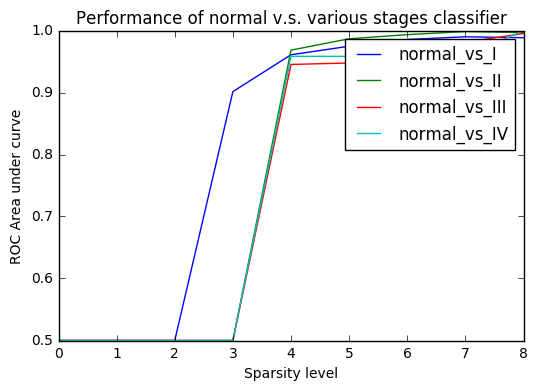

In [32]:
from matplotlib import pyplot as plt

for model, name in zip([normal_vs_I, normal_vs_II, normal_vs_III, normal_vs_IV], ['normal_vs_I', 'normal_vs_II', 'normal_vs_III', 'normal_vs_IV']):
    print list(model.scores_['normal'][1])
    plt.plot(list(model.scores_['normal'][1]), label=name)
    
plt.legend()
plt.ylabel('ROC Area under curve')
plt.xlabel('Sparsity level')
plt.title('Performance of normal v.s. various stages classifier')
plt.axis('tight')
plt.show()

In [45]:
for i in range(len(results)):
    for j in range(len(results)):
        print '\n', "Stage "+str(i+1)+' - Stage '+str(j+1), ' : ',len(set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist()))
        # print set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist())


Stage 1 - Stage 1  :  184

Stage 1 - Stage 2  :  75

Stage 1 - Stage 3  :  74

Stage 1 - Stage 4  :  47

Stage 2 - Stage 1  :  75

Stage 2 - Stage 2  :  140

Stage 2 - Stage 3  :  60

Stage 2 - Stage 4  :  44

Stage 3 - Stage 1  :  74

Stage 3 - Stage 2  :  60

Stage 3 - Stage 3  :  147

Stage 3 - Stage 4  :  43

Stage 4 - Stage 1  :  47

Stage 4 - Stage 2  :  44

Stage 4 - Stage 3  :  43

Stage 4 - Stage 4  :  103
